# Preprocessing steps for _isMuon_ models

In [1]:
import os
from IPython.display import Markdown
from gpu_picker import request_gpu

PARTICLE = os.environ.get("PARTICLE", "muon")
LOCAL = os.environ.get("LOCAL", "yes").lower() in ['y', 'yes', 'true', '1']
SAMPLE = os.environ.get("SAMPLE", "2016MU")

Markdown(f"""
 * PARTICLE: `{PARTICLE}`
 * LOCAL: `{LOCAL}`
 * SAMPLE: `{SAMPLE}`
 * REQUESTED GPU: `{request_gpu(False)}`
""")


 * LOCAL: `True`
 * SAMPLE: `2016MU`


## Technologies and libraries

On top of the standard Python echosystem we are using:
 * `uproot` to convert data from `ROOT TTrees` to `pandas DataFrames`
 * `dask DataFrame` to enable processing datasets larger than the available RAM. Dask takes care of flushing from disk to RAM the data, converting from ROOT to pandas data format on demand.
 * `Arrow Feather` data format to cache in local storage the training dataset
     * Note that custom wrappers to Dask and TensorFlow, as defined in `feather_io.py` are needed 

In [2]:
import uproot
import numpy as np
import pandas as pd
import dask.dataframe as ddf

from os import environ

## Loading data

In [3]:
from glob import glob

if LOCAL:
    if SAMPLE == "2016MU":
        file_pattern = "/tmp/LamarrTraining-j109*.root"
        default_file_list = glob(file_pattern)[:3]
else:
    # file_pattern = "/workarea/cloud-storage/anderlinil/LamarrBenderTrain/j109/*.root"
    default_file_list = []
    
file_list = os.environ.get("INPUT_FILES", " ".join(default_file_list)).split(" ")

print (f"Found {len(file_list)} data files")  

Found 1 data files


### Conversion from `ROOT TTree` to `Pandas DataFrame`

In [5]:
selections = [
  "probe_Brunel_ETA > 1.5",
  "probe_Brunel_ETA < 5.5",
  "nTracks_Brunel > 0",
  "nTracks_Brunel < 1000",
  "probe_Brunel_MuonUnbiased == 1",
]

cuts = " and ".join([f"({s})" for s in selections])

In [6]:
from functools import partial

sim = dict()

opened_files = [uproot.open(f) for f in file_list]

sim = (
    ddf.from_map(
        lambda f: pd.DataFrame(f[f"PidTupler/pid_{PARTICLE}"].arrays(library='np')),
        opened_files,
    ).query(cuts)
    )
    

IsADirectoryError: [Errno 21] Is a directory: '/home/private/lamarr/lb-pidsim-train/pidgan/workflow/notebooks'

### List of features

In [7]:
from IPython.display import HTML

HTML ("<UL>" + "\n".join(f"<LI> <PRE>{var}</PRE> " for var in sim.columns) + "</UL>")

## Features

In [8]:
sim["p_GeV"] = sim.probe_Brunel_P/1e3
# sim["log10_p"] = np.log10(sim.probe_Brunel_P)
sim["eta"] = sim.probe_Brunel_ETA
sim = sim.map_partitions(lambda df: df.assign(nTracks_f = df.nTracks_Brunel + np.random.uniform(-0.5, 0.5, len(df))))
sim["charge"] = sim.probe_Brunel_trackcharge

sim["isMuon"] = sim.probe_Brunel_isMuon

In [9]:
real_features = ["p_GeV", "eta", "nTracks_f"]
flag_features = ["charge"]

features = real_features + flag_features
labels = ["isMuon"]

In [10]:
from IPython.display import HTML

def list_vars(title, var_list):
    display(HTML (f"<P><B>{title}</B><UL>" + "\n".join(f"<LI> <PRE>{var}</PRE> " for var in var_list) + "</UL><HR>"))

list_vars("Input features (real)", real_features)
list_vars("Input features (boolean)", flag_features)
list_vars("Output features (real)", labels)

In [11]:
dfs = dict()
npartitions=min(len(file_list), 10)

dfs = sim[features + labels].head(500_000, npartitions=npartitions)
print(f"Number of {PARTICLE}s:", len(dfs))

Number of muons: 480314
Number of pions: 500000
Number of kaons: 500000
Number of protons: 500000


### Histograms

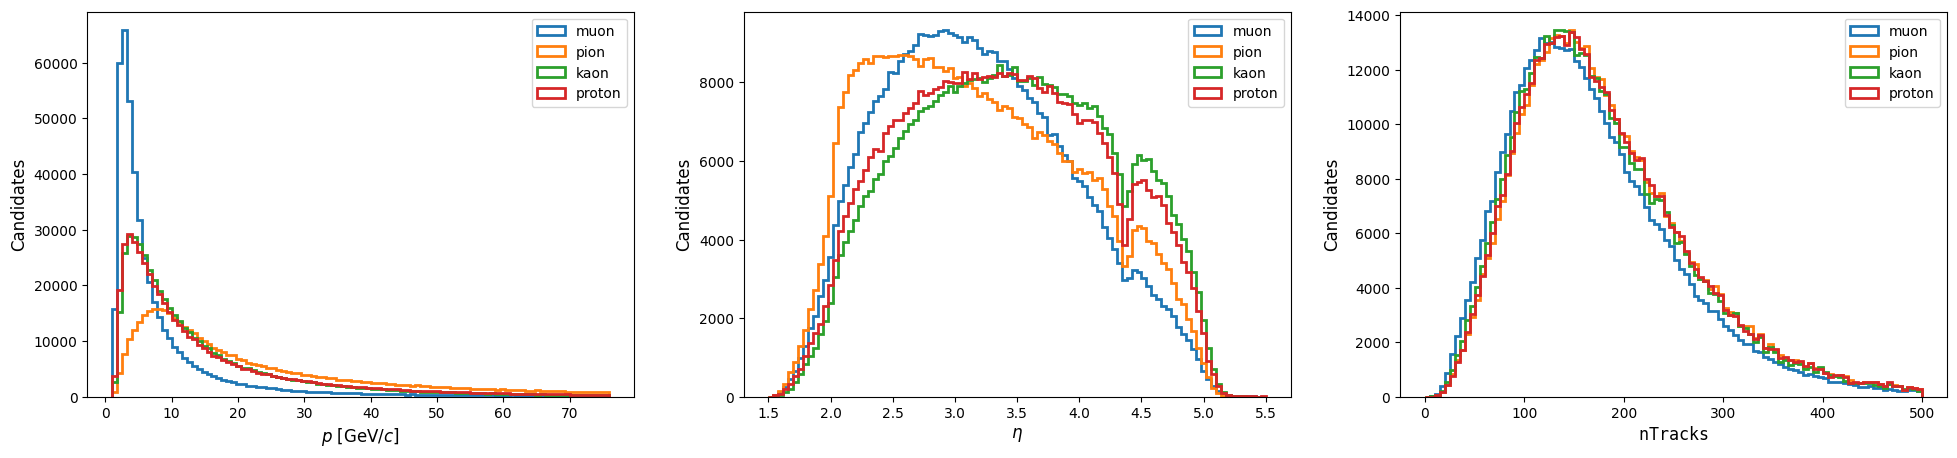

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(24, 5), dpi=100)

plt.subplot(1, 3, 1)
plt.xlabel(r"$p$ [GeV/$c$]", fontsize=12)
plt.ylabel(r"Candidates", fontsize=12)
plt.hist(dfs["p_GeV"], bins=np.linspace(1.0, 76.0, 101), histtype="step", lw=2, label=PARTICLE)
plt.legend(fontsize=10)

plt.subplot(1, 3, 2)
plt.xlabel(r"$\eta$", fontsize=12)
plt.ylabel(r"Candidates", fontsize=12)
plt.hist(dfs["eta"], bins=np.linspace(1.5, 5.5, 101), histtype="step", lw=2, label=PARTICLE)
plt.legend(fontsize=10)

plt.subplot(1, 3, 3)
plt.xlabel(r"$\mathtt{nTracks}$", fontsize=12)
plt.ylabel(r"Candidates", fontsize=12)
plt.hist(dfs["nTracks_f"], bins=np.linspace(0.0, 500.0, 101), histtype="step", lw=2, label=PARTICLE)
plt.legend(fontsize=10)

plt.show()

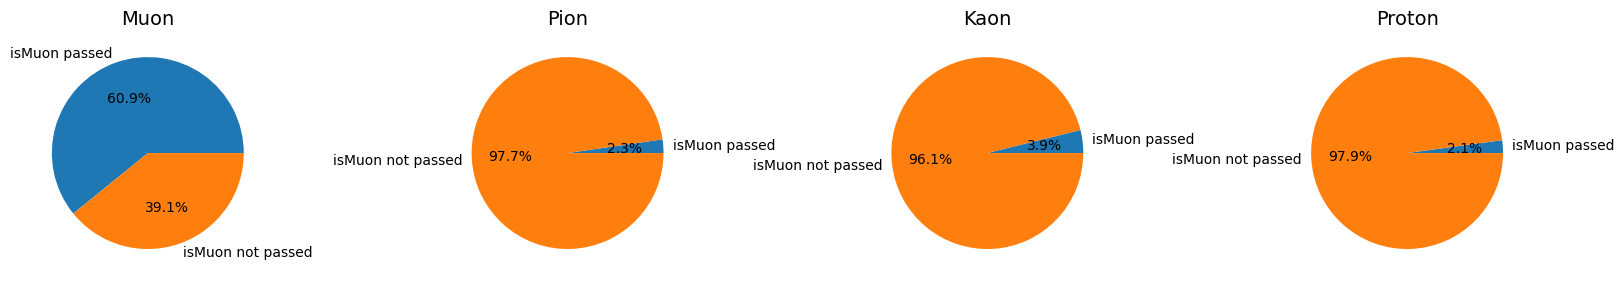

In [13]:
plt.figure(figsize=(16, 3))

plt.title(PARTICLE.capitalize(), fontsize=14)

categories = [np.count_nonzero(dfs["isMuon"].values)]
categories.append(len(dfs) - sum(categories))

plt.pie(categories, autopct="%1.1f%%", labels=["isMuon passed", "isMuon not passed"])

plt.tight_layout()
plt.show()

## Preprocessing

In [14]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import QuantileTransformer, FunctionTransformer

n_features = len(real_features)
n_flags = len(flag_features)

prep_step = ColumnTransformer(
    [
        ('features', QuantileTransformer(output_distribution='normal'), np.arange(n_features)),
        ('flags', "passthrough", n_features + np.arange(n_flags)),
    ]
).fit(dfs[features].values)

In [16]:
from preprocessing_utils import store_as_pickle

display(
    store_as_pickle(
        prep_step,
        f"PREPROCESSING_X",
        f"/tmp/lb-pidsim-train/models/isMuon_{PARTICLE}_models/tX_{SAMPLE}.pkl",
    )
)

display(
    # Simply a placeholder
    store_as_pickle(
        FunctionTransformer(None),
        f"PREPROCESSING_Y",
        f"/tmp/lb-pidsim-train/models/Rich_{PARTICLE}_models/tY_{SAMPLE}.pkl",
    )
)

## Train, test and validation

The dataset is split in:
 * *train* (50%) used for training the model
 * *test* (40%) used for measuring the performance of the model
 * *validation* (10%) used in combination with the train dataset to check for overtraining effects
 
Split data is stored on disk in chunks of 100 MB (before compression).

In [ ]:
DATA_PATH = os.environ.get("DATA_PATH", "/tmp/lb-pidsim-train/data")
os.makedirs(DATA_PATH, exist_ok=True)

In [ ]:
from preprocessing_utils import split_and_store, peek_from_dataset

from IPython.display import Markdown

display(Markdown(f"# {PARTICLE.capitalize()}"))

entries = split_and_store(
    sim[features + labels],
    [
        (0.5, os.environ.get(f"TRAIN", f"{DATA_PATH}/isMuon-{PARTICLE}-{SAMPLE}-train")),
        (0.4, os.environ.get(f"TEST", f"{DATA_PATH}/isMuon-{PARTICLE}-{SAMPLE}-test")),
        (0.1, os.environ.get(f"VALIDATION", f"{DATA_PATH}/isMuon-{PARTICLE}-{SAMPLE}-validation"))
    ],
    chunksize="80MB",
    features=features,
    labels=labels,
    preprocessorX=prep_step,
)
    
display(pd.DataFrame(entries, index=["Train", "Test", "Validation"]))

X, y = peek_from_dataset(      
    f"TRAIN", 
    f"{DATA_PATH}/isMuon-{PARTICLE}-{SAMPLE}-train",
)
 
## X Variables
plt.figure(figsize=(32, 5), dpi=100)

for i, x_var in enumerate(features):
    plt.subplot(1, 4, i+1)
    plt.xlabel(x_var, fontsize=12)
    plt.ylabel("Candidates", fontsize=12)
    plt.hist(X[:, i].numpy()[:100000], bins=100)

plt.show()

